In [1]:
pip install watermark

In [2]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import keras.layers as layers
from keras.models import Model
from keras.preprocessing import image
from keras import backend as K 
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# 1. magic so that the notebook will reload external python modules
# 2. magic for inline plot
# 3. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
# 4. magic to print version
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext watermark

%watermark -a 'Ethen' -d -t -v -p cv2,keras,numpy,matplotlib,tensorflow

Using TensorFlow backend.


Ethen 2020-05-08 13:01:00 

CPython 3.6.9
IPython 5.5.0

cv2 4.1.2
keras 2.3.1
numpy 1.18.3
matplotlib 3.2.1
tensorflow 2.2.0rc4


In [0]:
from keras.initializers import glorot_uniform


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """ 
    An identity block.

    Parameters
    ----------
    input_tensor:

    kernel_size: int
        The kernel size of middle conv layer at main path.

    filters: list[int]
        The filters of 3 conv layer at main path.

    stage: int
        Current stage label, used for generating layer names.

    block: : str
        'a','b'..., current block label, used for generating layer names.

    Returns
    -------
    Output tensor for the block.
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # for batch normalization layer, we assume
    # the input data is in channel last format
    bn_axis = 3

    filters1, filters2, filters3 = filters
  
    # The kernel_initializer is only used
    # for better performance
    x = layers.Conv2D(filters1, kernel_size=(1, 1), strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, kernel_size=(1, 1), strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    # this line the skip connection, one that sets ResNet apart
    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

In [0]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """ 
    A block that has a conv layer at shortcut.

    Parameters
    ----------
    input_tensor:
    
    kernel_size: int
        The kernel size of middle conv layer at main path.

    filters: list[int]
        The filters of 3 conv layer at main path.

    stage: int
        Current stage label, used for generating layer names.

    block: : str
        'a','b'..., current block label, used for generating layer names.
        
    strides : tuple, default (2, 2)
        Strides for the first conv layer in the block.

    Returns
    -------
    Output tensor for the block.
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # for batch normalization layer, we assume
    # the input data is in channel last format,
    # which is the case if we are using the default
    # keras' backend tensorflow
    bn_axis = 3

    filters1, filters2, filters3 = filters
  
    # main path, note that setting the kernel_initializer set here is only used
    # for reproducibility, we techniqually don't need it
    x = layers.Conv2D(filters1, kernel_size=(1, 1), strides=strides,
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, kernel_size=(1, 1), strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    
    # we resize the input so its dimension will match the output dimension
    # of the main path
    shortcut = layers.Conv2D(filters3, kernel_size=(1, 1), strides=strides,
                             kernel_initializer=glorot_uniform(seed=0),
                             padding='valid', name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut) 

    # this line is the core component of resnet, the skip connection, i.e.
    # having a shortcut to the main path before the activation
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [6]:
from keras.datasets import mnist
from keras.utils import np_utils

img_rows, img_cols, num_classes = 28, 28, 10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('x_train shape:', x_train.shape)


11493376/11490434 [==============================] - 3s 0us/step
x_train shape: (60000, 28, 28)


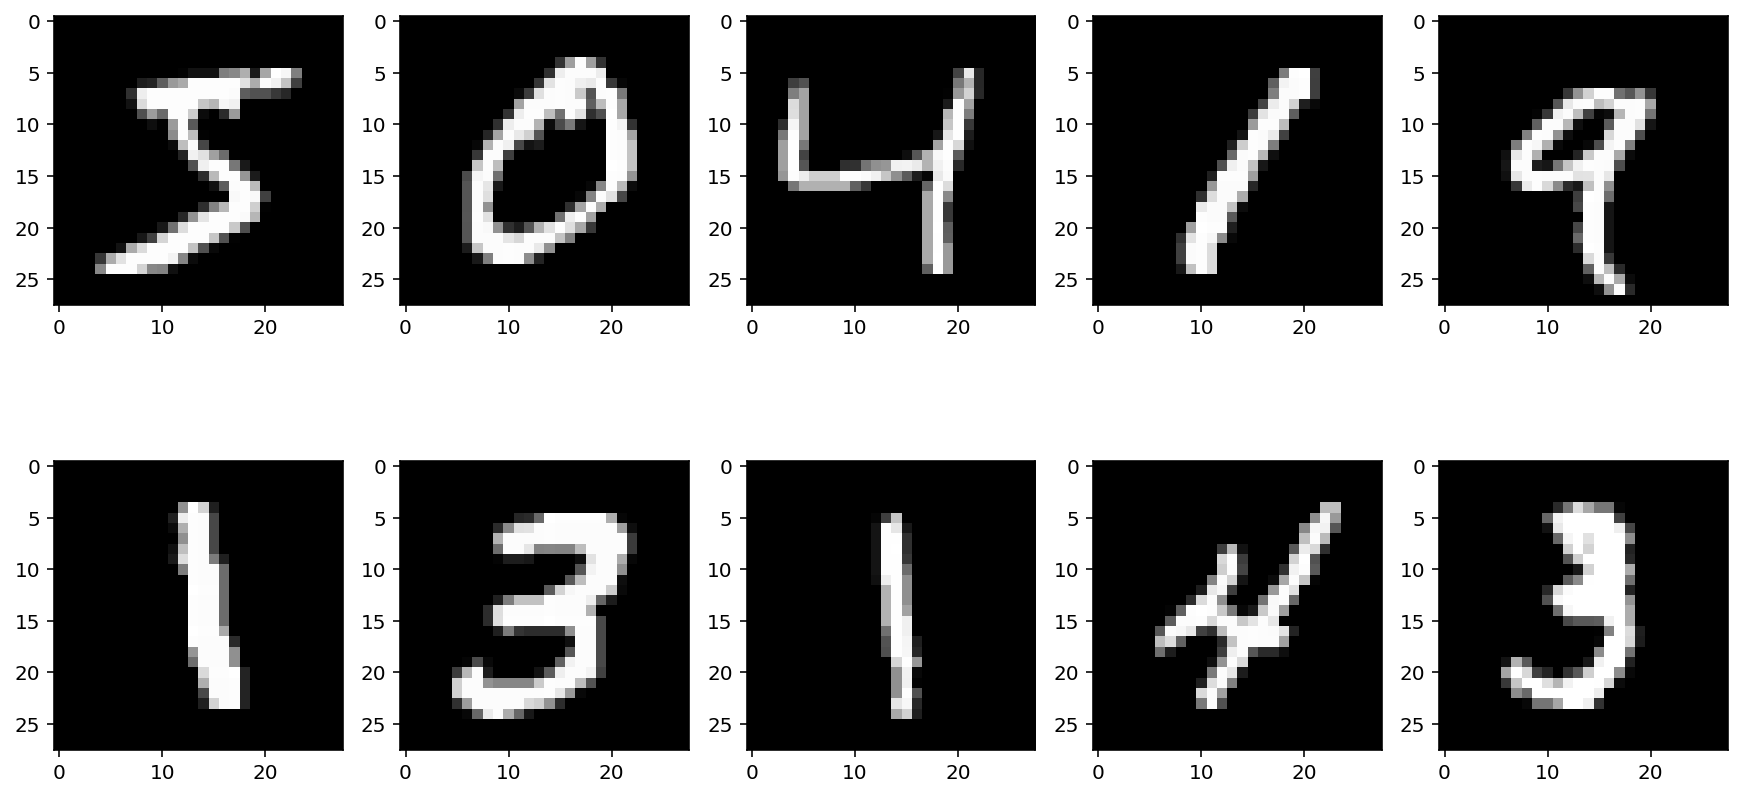

Labels : [5 0 4 1 9]
Labels : [1 3 1 4 3]


In [7]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_train[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

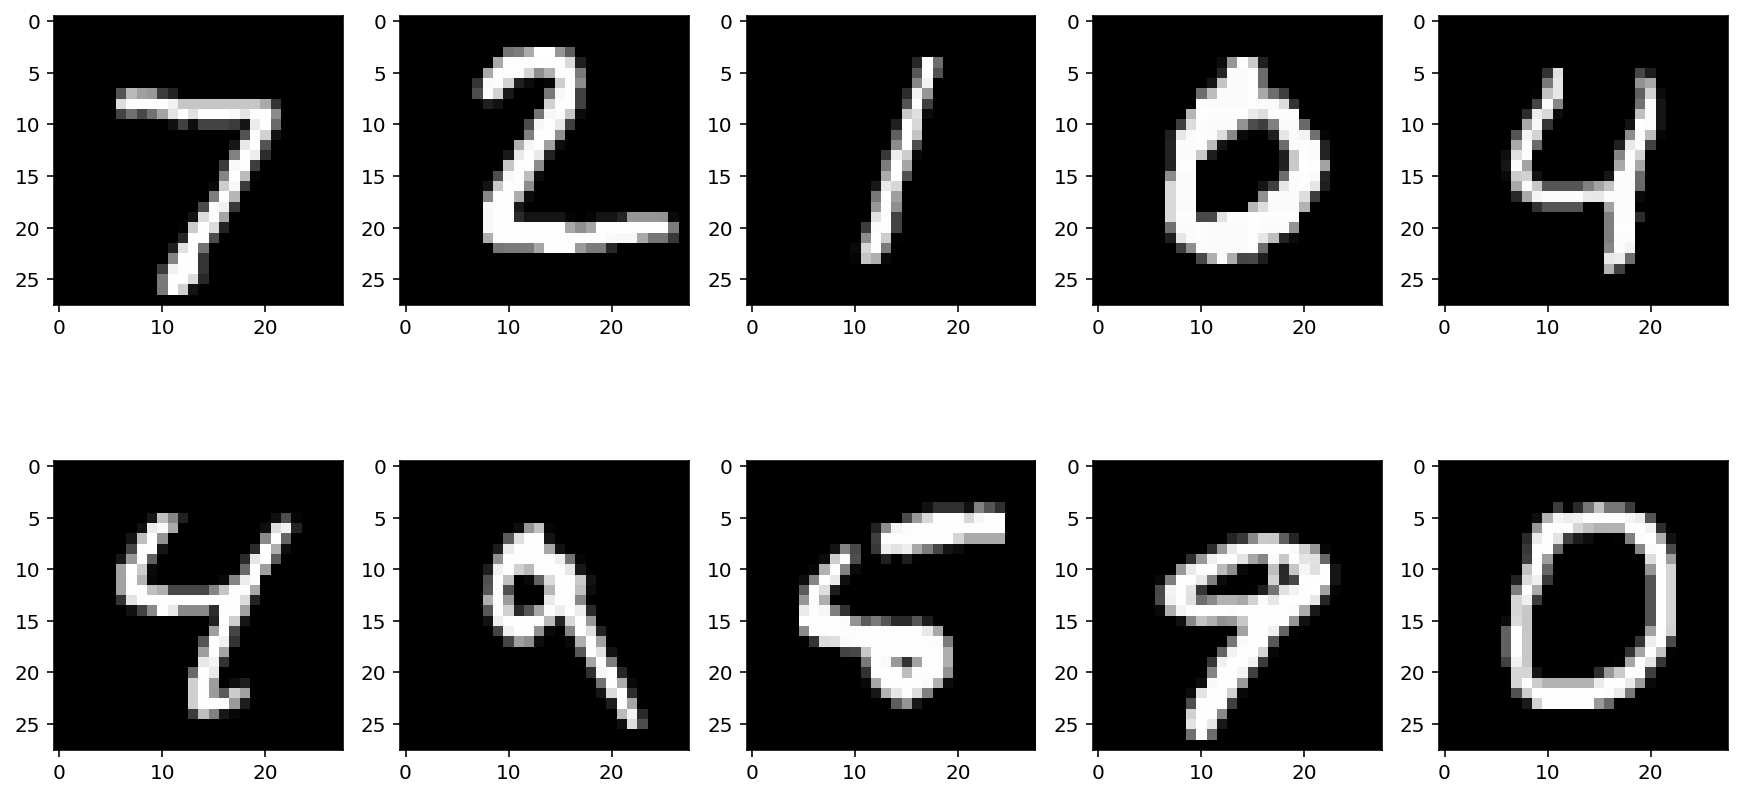

Labels : [7 2 1 0 4]
Labels : [4 9 5 9 0]


In [0]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_test[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_test[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_test[0:5]))
print("Labels : {}".format(y_test[6:11]))

In [10]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
print(input_shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

(28, 28, 1)
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [11]:
def ResNet(input_shape, n_classes):
    """
    Definition of ResNet
    
    References
    ----------
    https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
    """
    img_input = layers.Input(shape=input_shape)
    
    bn_axis = 3
    
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),strides=(2, 2),padding='valid', kernel_initializer='he_normal', name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    
    
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    img_output = layers.Dense(n_classes, activation='softmax', name='fc' + str(n_classes))(x)

    model = Model(inputs=img_input, outputs=img_output, name='resnet')
    return model


model = ResNet(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 34, 34, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 14, 14, 64)   256         conv1[0][0]                      
_____________________________________________________________________________________________

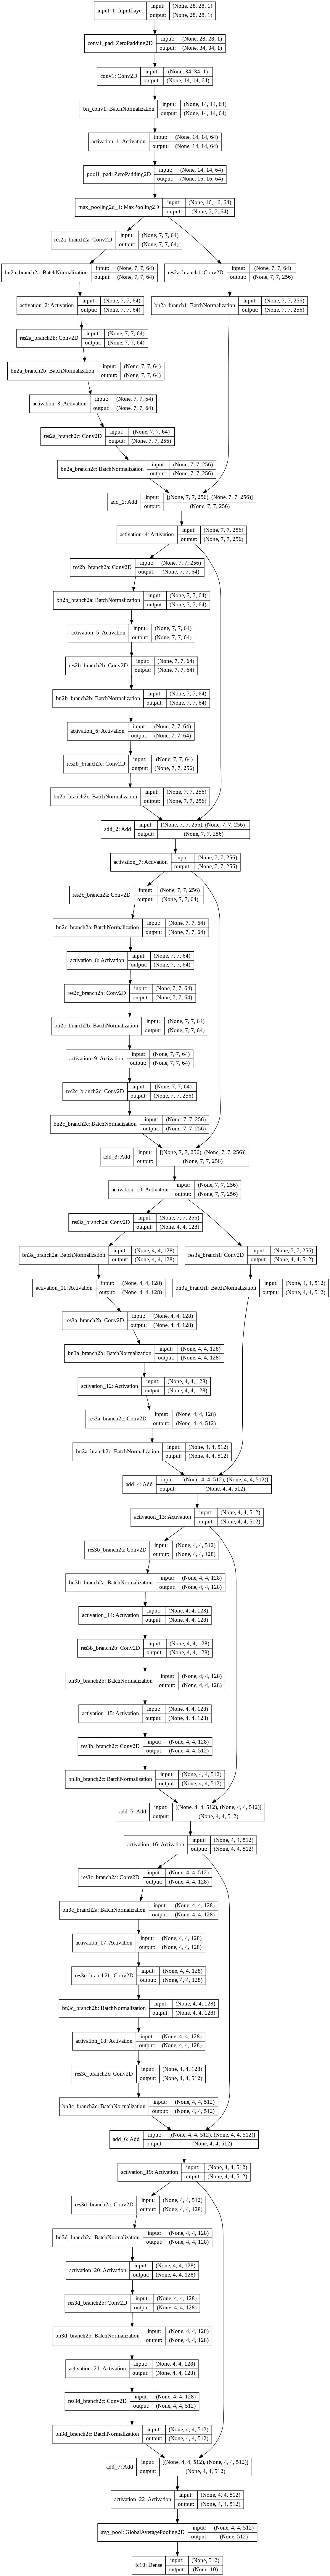

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='ResNet30_MNIST.png', show_shapes=True, show_layer_names=True)

In [0]:
def test_accuracy():
    tp = []
    err = []
    t = 0
    predictions = model.predict(x_test, verbose=1)
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == np.argmax(y_test[i])):
            t = t+1
            tp.append(i)
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err, tp

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
def plot_miss():
  fig1 = plt.figure(figsize = (15,15))

  for i in range(5):
      ax1 = fig1.add_subplot(1,5,i+1) 
      ax1.imshow(x_test[p[2][i]].reshape(28,28)*255, interpolation='none', cmap=plt.cm.gray)
      ax2 = fig1.add_subplot(2,5,i+6) 
      ax2.imshow(x_test[p[2][i+6]].reshape(28,28)*255, interpolation='none', cmap=plt.cm.gray)
  plt.show()

  result = (np.where((y_test[p[2][0:5]])))[1]
  print("True:          {}".format(result))
  print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

  result = (np.where((y_test[p[2][6:11]])))[1]
  print("True:          {}".format(result))
  print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))


In [0]:
def plot_right():
  fig1 = plt.figure(figsize = (15,15))

  for i in range(5):
      ax1 = fig1.add_subplot(1,5,i+1) 
      ax1.imshow(x_test[p[2][i]].reshape(28,28)*255, interpolation='none', cmap=plt.cm.gray)
      ax2 = fig1.add_subplot(2,5,i+6) 
      ax2.imshow(x_test[p[3][i+6]].reshape(28,28)*255, interpolation='none', cmap=plt.cm.gray)
  plt.show()

  result = (np.where((y_test[p[3][0:5]])))[1]
  print("True:          {}".format(result))
  print("classified as: {}".format(np.argmax(predictions[p[3][0:5]], axis=1)))

  result = (np.where((y_test[p[3][6:11]])))[1]
  print("True:          {}".format(result))
  print("classified as: {}".format(np.argmax(predictions[p[3][6:11]], axis=1)))

In [0]:
h = model.fit(x_train, y_train, epochs=20, batch_size=16, validation_data = (x_test,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 140s 2ms/step - loss: 0.1564 - accuracy: 0.9535 - val_loss: 0.1658 - val_accuracy: 0.9551
Epoch 2/20
60000/60000 [==============================] - 134s 2ms/step - loss: 0.0698 - accuracy: 0.9794 - val_loss: 0.1316 - val_accuracy: 0.9656
Epoch 3/20
60000/60000 [==============================] - 135s 2ms/step - loss: 0.0499 - accuracy: 0.9849 - val_loss: 0.0607 - val_accuracy: 0.9822
Epoch 4/20
60000/60000 [==============================] - 134s 2ms/step - loss: 0.0367 - accuracy: 0.9891 - val_loss: 0.0419 - val_accuracy: 0.9884
Epoch 5/20
60000/60000 [==============================] - 134s 2ms/step - loss: 0.0312 - accuracy: 0.9908 - val_loss: 0.0225 - val_accuracy: 0.9923
Epoch 6/20
60000/60000 [==============================] - 136s 2ms/step - loss: 0.0230 - accuracy: 0.9928 - val_loss: 0.0402 - val_accuracy: 0.9882
Epoch 7/20
60000/60000 [==============================] - 137s

In [0]:
final_loss, final_acc = model.evaluate(x_test, y_test, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

NameError: ignored

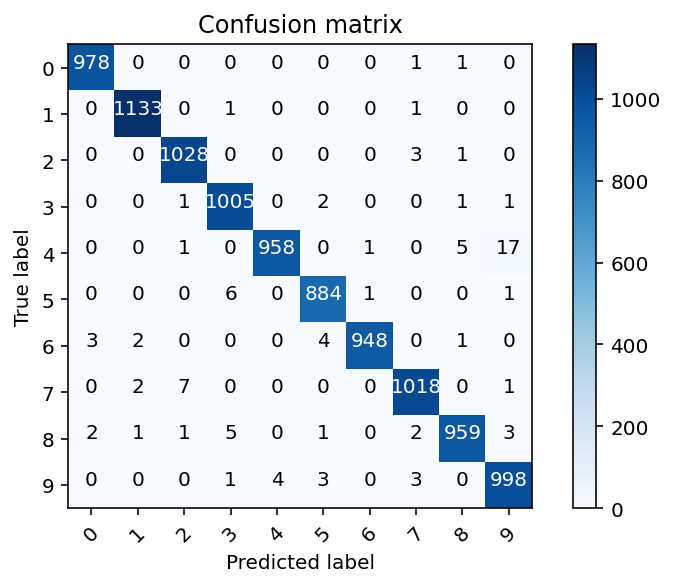

In [0]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


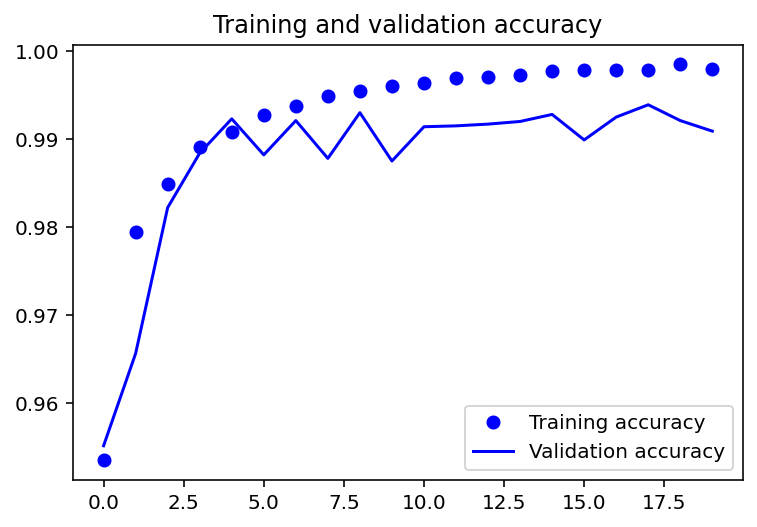

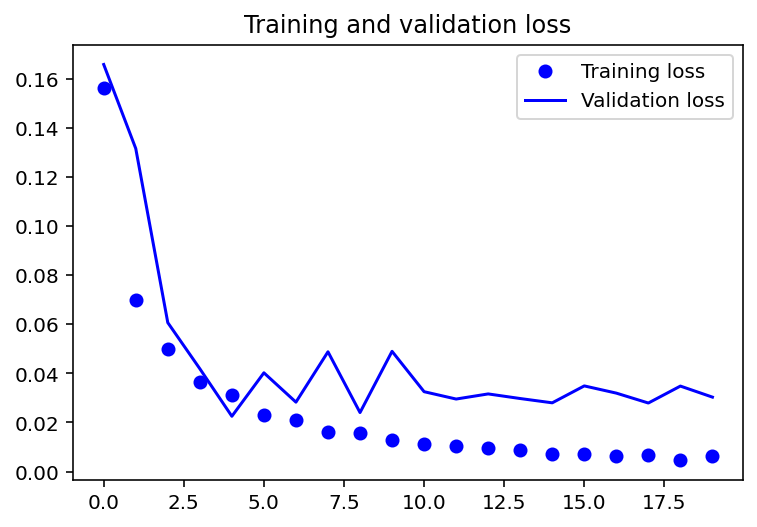

In [0]:
print(h.history.keys())
accuracy = h.history['accuracy']
val_accuracy = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

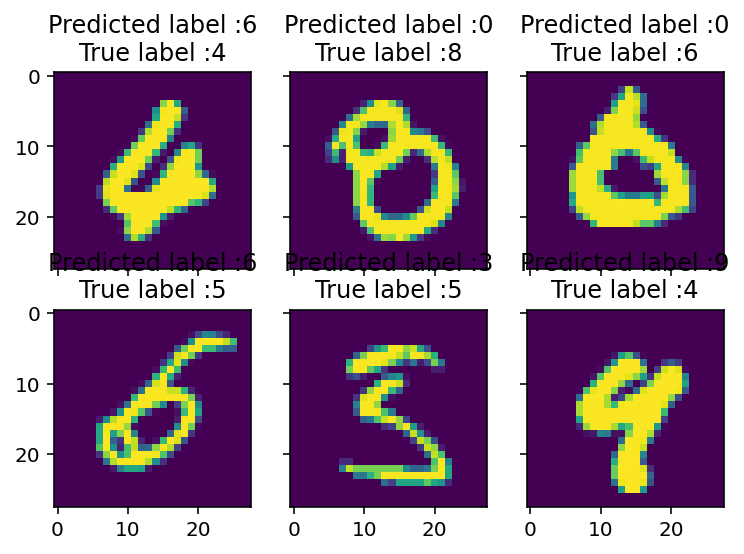

In [0]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

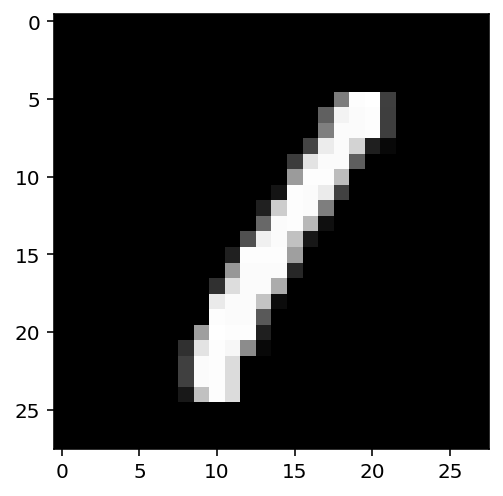

In [0]:
test_im = x_train[3]
plt.imshow(test_im.reshape(28,28), cmap='gray', interpolation='none')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


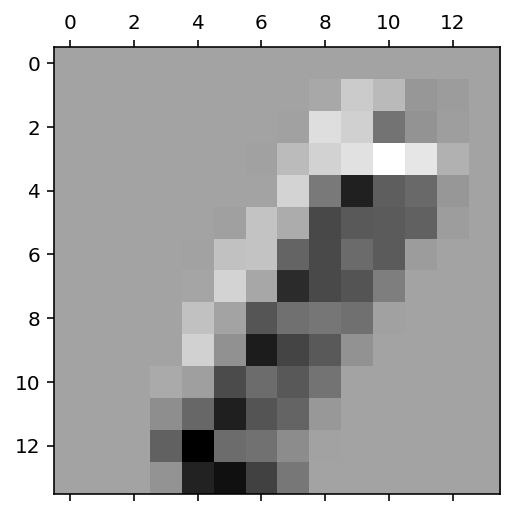

In [0]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(input=model.input, output=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,28,28,1))

second_layer_activation = activations[2]
plt.matshow(second_layer_activation[0, :, :, 4], cmap='gray')

In [0]:
model.layers[:-1]

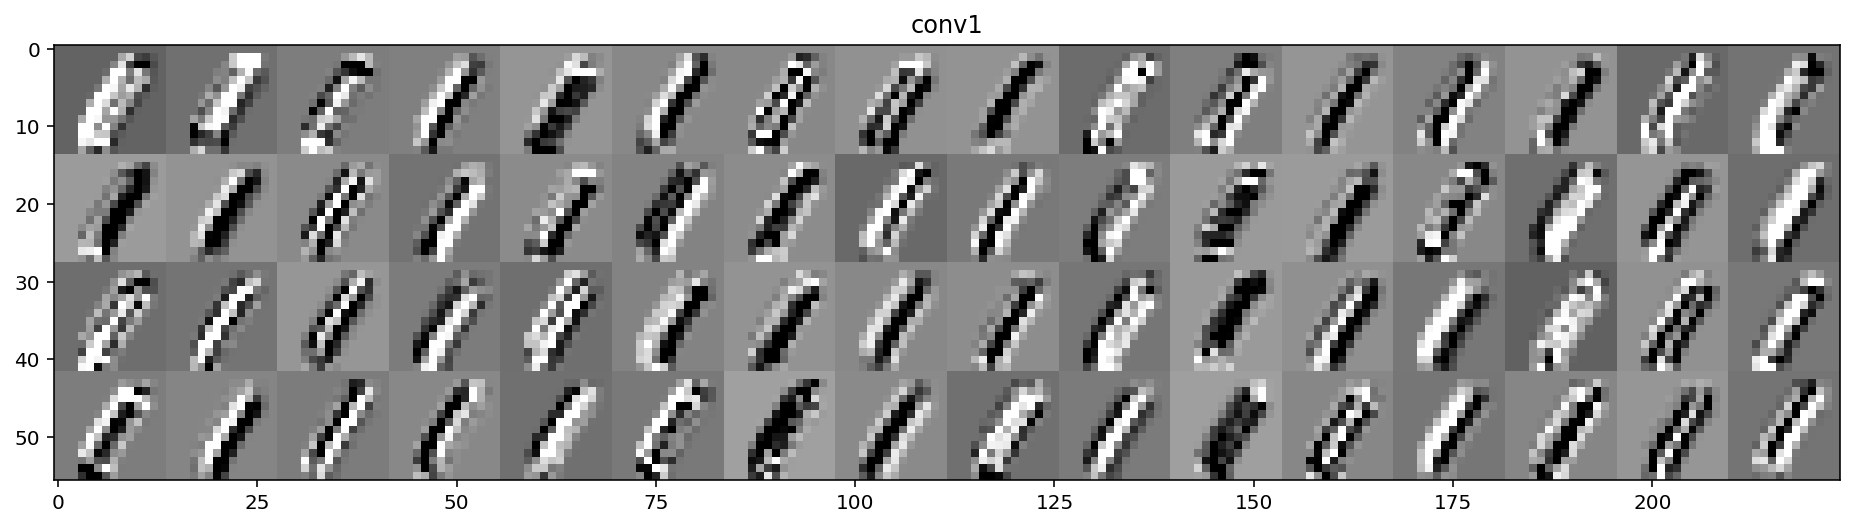

In [0]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name == 'conv1':
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

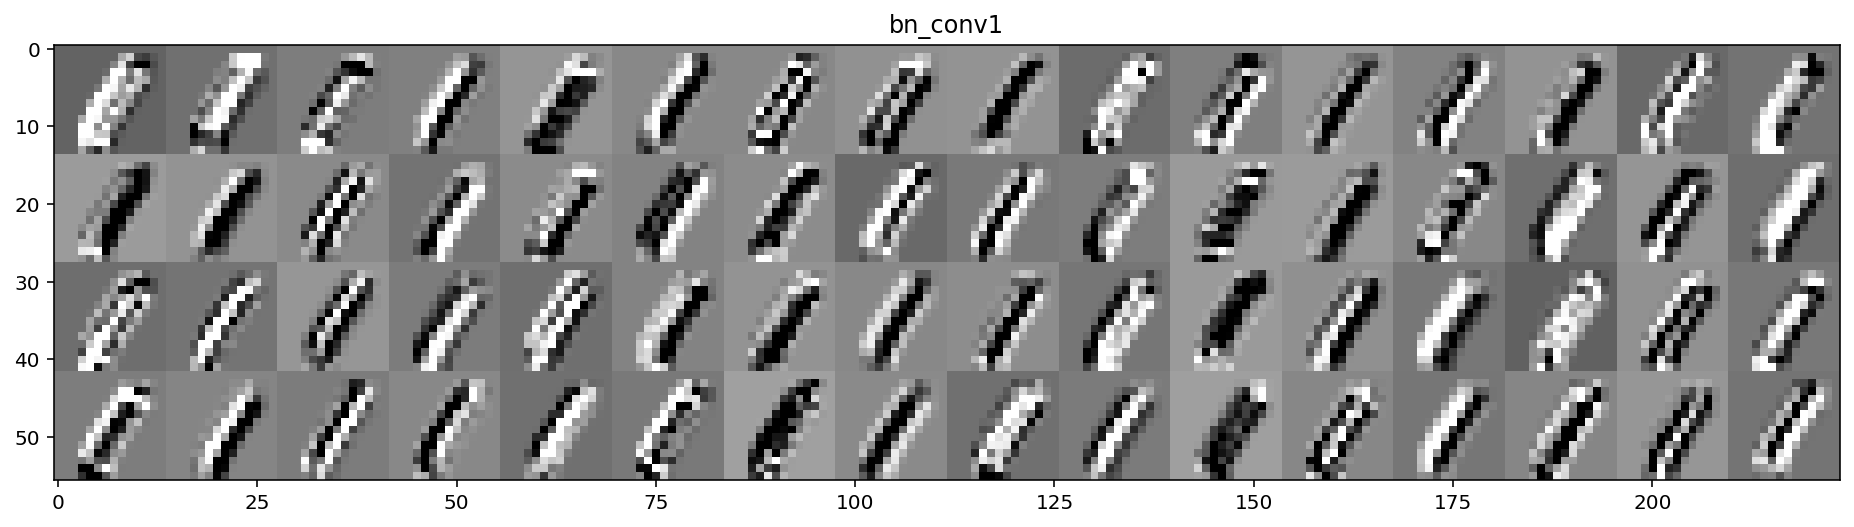

In [0]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('bn'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

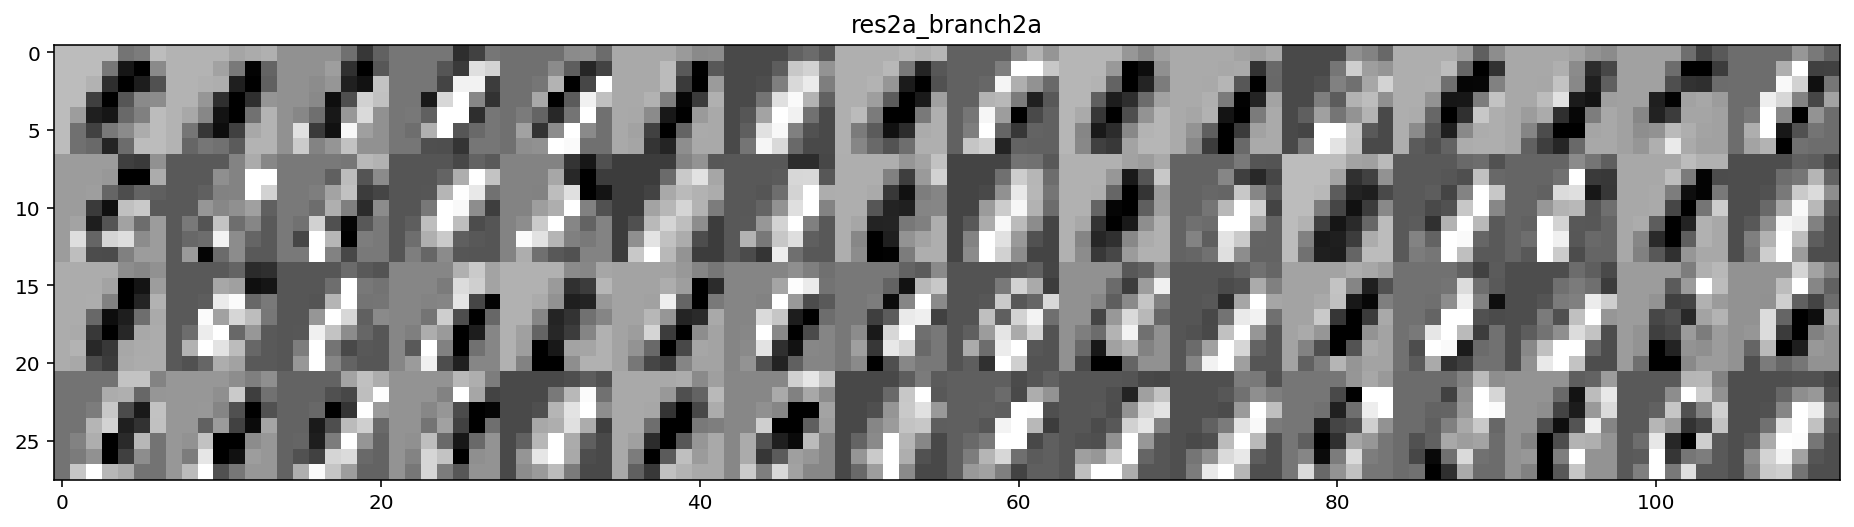

In [0]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('res'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

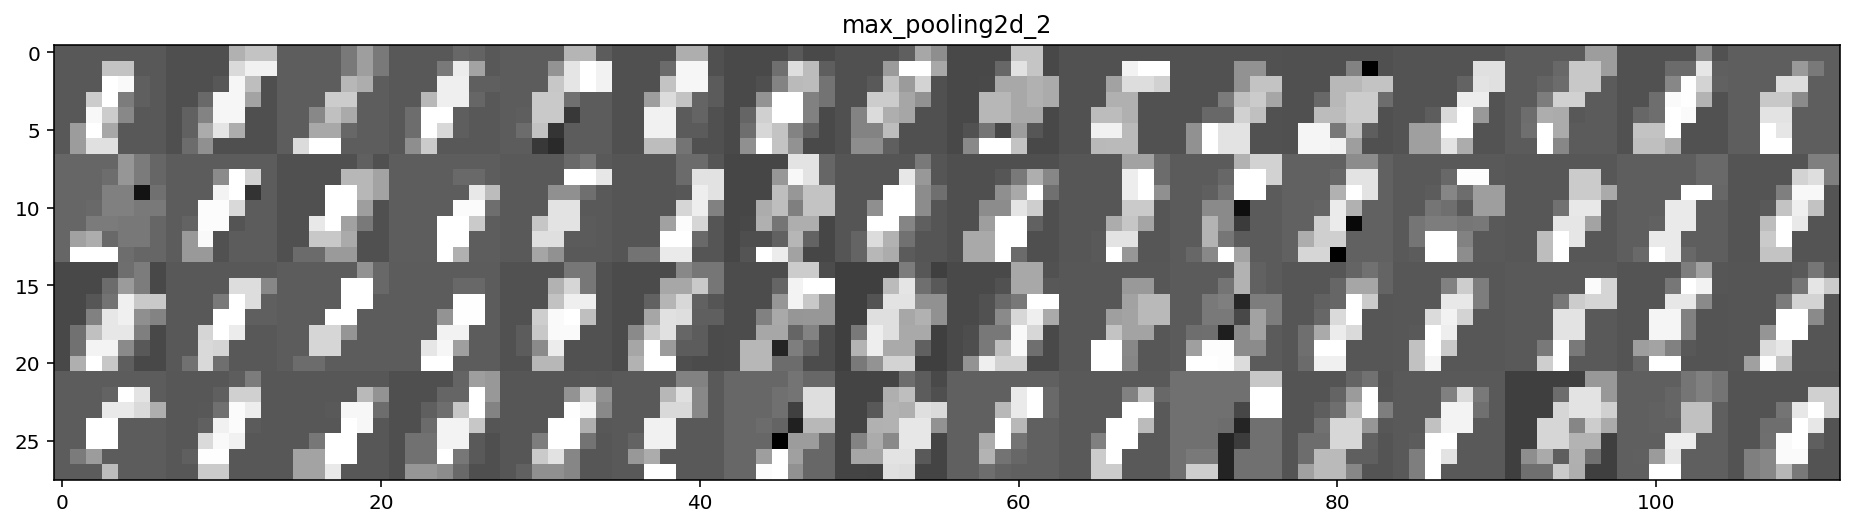

In [0]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('max'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

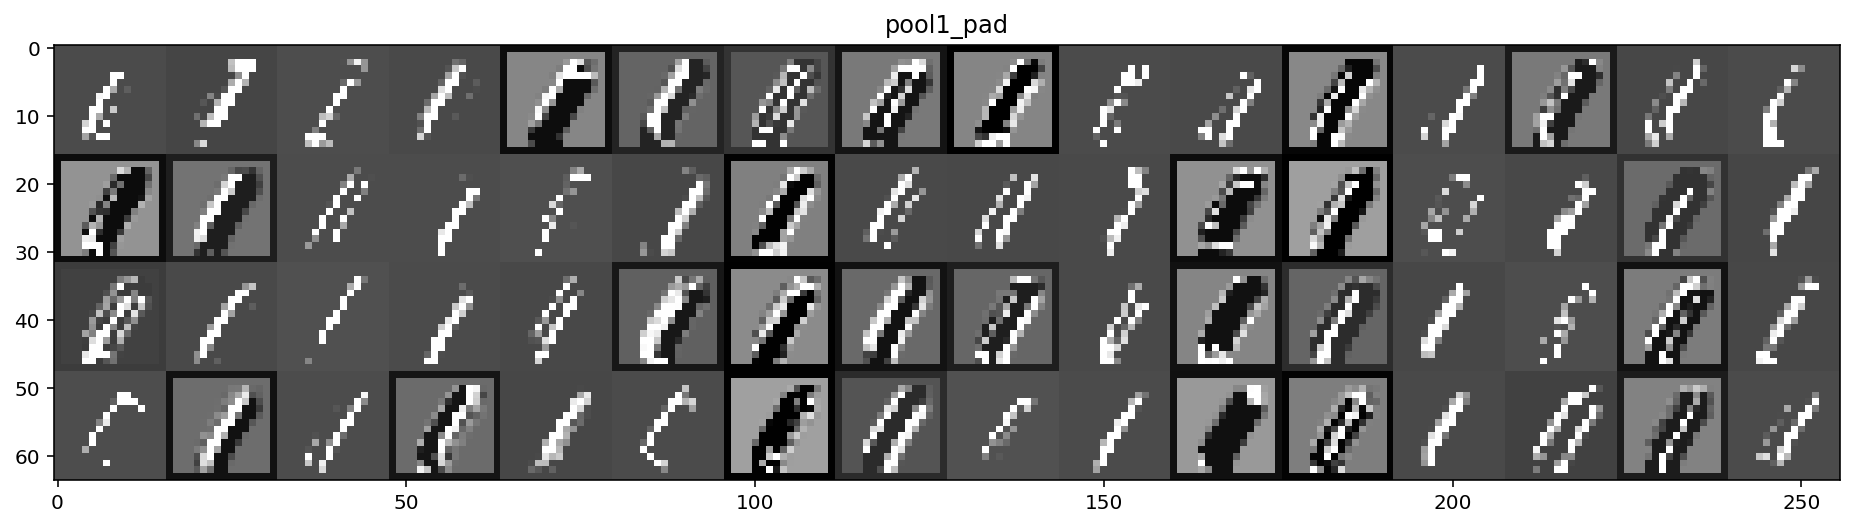

In [0]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('pool'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

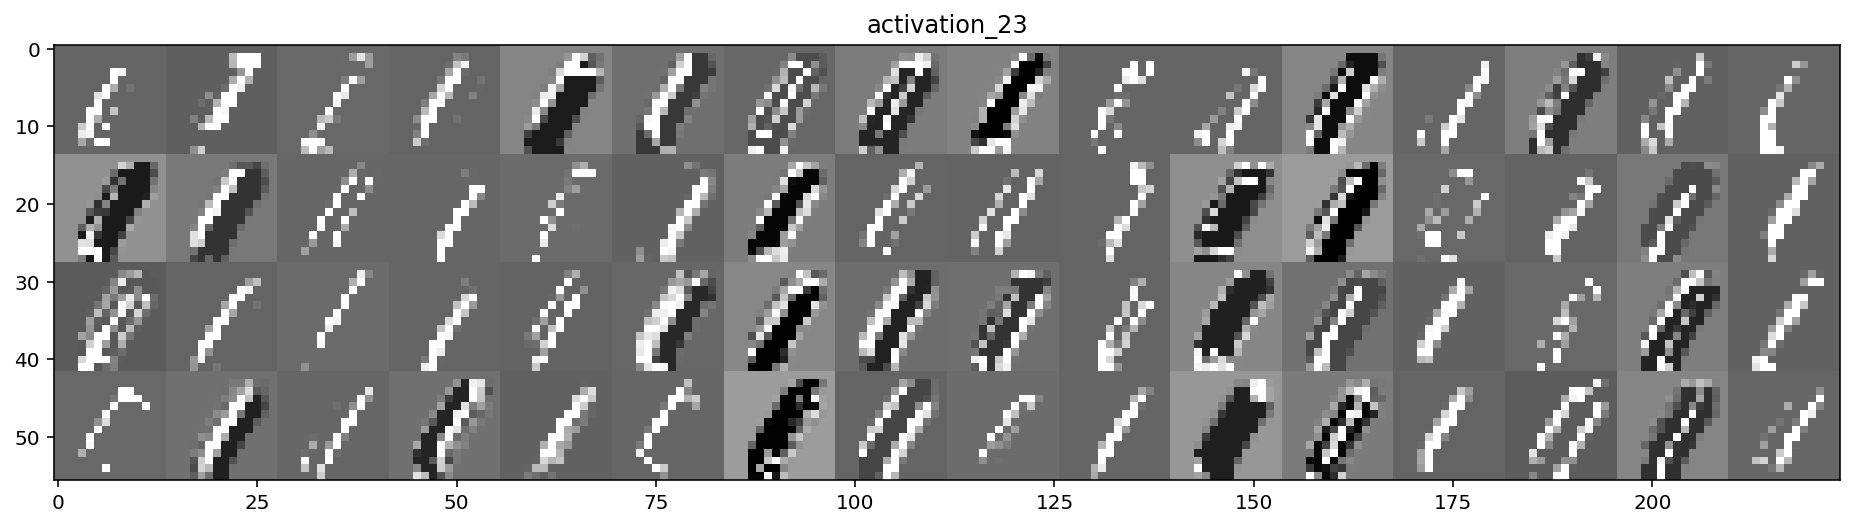

In [0]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('activation'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

In [0]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true_classes = np.argmax(y_test, axis = 1)

In [0]:
Y_pred_classes[:5], Y_true_classes[:5]

(array([7, 2, 1, 0, 4]), array([7, 2, 1, 0, 4]))

In [0]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(Y_true_classes, Y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.99      1.00      1.00       980
     Class 1       1.00      1.00      1.00      1135
     Class 2       0.99      1.00      0.99      1032
     Class 3       0.99      1.00      0.99      1010
     Class 4       1.00      0.98      0.99       982
     Class 5       0.99      0.99      0.99       892
     Class 6       1.00      0.99      0.99       958
     Class 7       0.99      0.99      0.99      1028
     Class 8       0.99      0.98      0.99       974
     Class 9       0.98      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

